<a href="https://colab.research.google.com/github/finlaycm/tensorflow_tumor_detection/blob/master/tumor_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help in OH if you're stuck.

### Reminder

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), or use all the available data. 


## Initial Code


In [ ]:
from google.colab import drive
import os
colab_root_dir = '/content'
drive_dir='/content/drive'
project_root_dir = os.path.join(drive_dir,'My Drive','deeplearning','cancer_classification')
tumor_dir = os.path.join(project_root_dir,'tumors')
data_dir = os.path.join(project_root_dir,'data')
eval_dir = os.path.join(project_root_dir,'eval')
drive.mount(drive_dir)
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
###Modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2 as cv
import json
import pathlib
import random
import pandas as pd
import time
import shutil
from time import gmtime, strftime
import sklearn
import time 
import matplotlib.image as mpimg
import random

import xml.etree.ElementTree as et 



%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten, Input, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K


### read directory with slides , masks and annotation files
slide_dir=os.path.join(project_root_dir,'myslides')
slide_files = [os.path.join(slide_dir,s) for s in os.listdir(slide_dir)]
mask_dir=os.path.join(project_root_dir,'mymasks')
mask_files = [os.path.join(mask_dir,m) for m in os.listdir(mask_dir)]
xml_dir=os.path.join(project_root_dir,'myannotations')
xml_files = [os.path.join(xml_dir,x) for x in os.listdir(xml_dir)]

###Functions
def read_slide(slide_path, level, x = 0, y = 0, width=None, height=None, as_float=False, show=False):
    slide = open_slide(slide_path)
    if not width: width=slide.level_dimensions[level][0]
    if not height: height=slide.level_dimensions[level][1]
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    if '_mask.tif' in str(slide_path):
      im = im[:,:,0]
    if show:
      plt.imshow(im)
      plt.show()
    return im
def tumor_idx(mask, level, x , y , width, height):
    im = mask.read_region((x,y), level, (width, height))
    im = np.asarray(im)[:,:,0]
    tumor_idx = im.sum()/(width*height)
    return tumor_idx
def save_patch(slide, level, x , y , width, height,patch_path):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    im = np.asarray(im)
    Image.fromarray(im).save(patch_path)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 n

## Slides and masks at different zoom levels

tumor_091


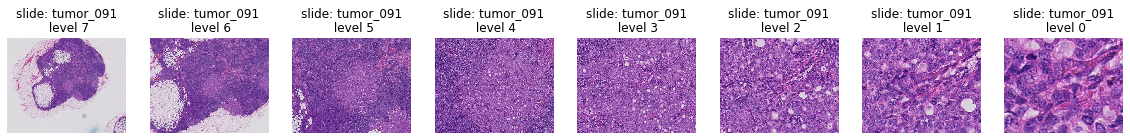

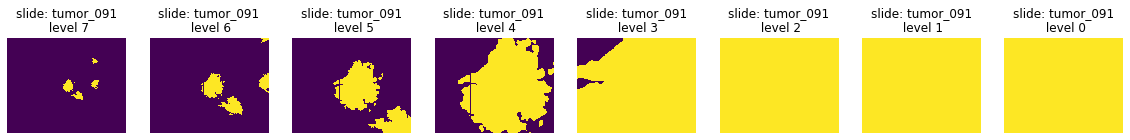

In [ ]:
slide_path= [s for s in slide_files if 'tumor_091' in s][0]
slide_title = pathlib.Path(slide_path).stem
mask_path =[m for m in mask_files if slide_title in m][0]
print(slide_title)
w, h =open_slide(slide_path).level_dimensions[0]
epsx, epsy = w//9, w//6
w, h = w - epsx, h - epsy
x, y = 0, 0
fig,axs = plt.subplots(nrows=1,ncols=8,figsize=(20,3))
for l in range(7,-1,-1):
  lw = w//2**(7)
  lh = h//2**(7)
  x =w//2+epsx-lw*2**l//2
  y = h//2+epsy - lh*2**l//2
  title='slide: {}\n level {}'.format(slide_title,l)
  im = read_slide(slide_path,l, x, y, lw, lh)
  axs[7-l].set_title(title)
  axs[7-l].imshow(im)
  axs[7-l].axis('off')
fig,axs = plt.subplots(nrows=1,ncols=8,figsize=(20,3))
for l in range(7,-1,-1):
  lw = w//2**(7)
  lh = h//2**(7)
  x =w//2+epsx - lw*2**l//2
  y = h//2+epsy - lh*2**l//2
  title='slide: {}\n level {}'.format(slide_title,l)
  im = read_slide(mask_path,l, x, y, lw, lh)
  if im.sum()==im.shape[0]*im.shape[1]:
    im_copy=im.copy()
    im_copy[0][0]=0
    im=im_copy
  if im.sum()==0:im[0][0]=1
  axs[7-l].set_title(title)
  axs[7-l].imshow(im)
  axs[7-l].axis('off')

## Read XML files to identify areas with tumors to extract extract enough positive and negative samples for training the model

Save image of tumor region

Save the coordinates of the region surrounding the the tumors in a pandas dataset

In [ ]:
###make dir 'tumors' is it does not exist to save tumor masks
xml_root = [[f, et.parse(f).getroot()]  for f in xml_files]
tumors= []
for xml_file, root in xml_root:
  slide_name = pathlib.Path(xml_file).stem
  slide_path = [s for s in slide_files if slide_name in s][0]
  mask_path = os.path.join(mask_dir,slide_name+'_mask.tif')
  tumors_len = len([node for node in root[0]])
  for t in range(tumors_len):
    PartOfGroup = root[0][t].attrib.get("PartOfGroup")
    if PartOfGroup != '_2':
      tumor_name = '{}_{}'.format(slide_name,t)
      tumor_mask_path= os.path.join(project_root_dir,'tumors',tumor_name+'_mask.jpg')
      x = min([int(float(p.attrib.get("X")))  for p in root[0][t][0]])//256*256
      w = (max([int(float(p.attrib.get("X")))  for p in root[0][t][0]]) + 256)//256*256 - x
      y = min([int(float(p.attrib.get("Y"))) for p in root[0][t][0]])//256*256
      h = (max([int(float(p.attrib.get("Y"))) for p in root[0][t][0]]) + 256)//256*256 - y
      x = max(0, x - 256)
      y = max (0, y - 256)
      w = w + 512
      h = h + 512
      tumor = [slide_path,mask_path,slide_name,tumor_mask_path,tumor_name,int(x),int(y),int(w),int(h)]
      #print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
      tumors.append(tumor)
      level = 3
      w = w//2**level
      h = h//2**level
      tumor_image = read_slide(mask_path, level, x,y,w,h)
      Image.fromarray(tumor_image*255).save(tumor_mask_path)  
# ###Tumor dataset
tumor_columns= ['slide_path','mask_path','slide_name','tumor_mask_path','tumor_name','x','y','width','height']
tumor_rows = [{'slide_path':t[0],'mask_path':t[1],'slide_name':t[2]
               ,'tumor_mask_path':t[3],'tumor_name':t[4],'x':t[5],'y':t[6],'width':t[7],'height':t[8]} for t in tumors]
tumors_df2 = pd.DataFrame(tumor_rows, columns = tumor_columns)
tumors_df2.to_pickle(os.path.join(project_root_dir,'tumors_df2.pkl'))
def show_random_tumors():
  tumor_jpgs = [t for t in tumors_df2['tumor_mask_path']]
  sample_tumor_jpgs = random.sample(tumor_jpgs,10)
  fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(12,8))
  for i in range(len(sample_tumor_jpgs)):
    img=mpimg.imread(sample_tumor_jpgs[i])
    title='{}\nimage size: {}\n(*) at level 3'.format(pathlib.Path(sample_tumor_jpgs[i])
                    .stem.replace('_mask',''),img.shape)
    axs[i//5][i%5].set_title(title)
    axs[i//5][i%5].imshow(img)
    axs[i//5][i%5].axis('off')
    if i == 0: a = img

## Image of random tumors 
Extracted from XML files

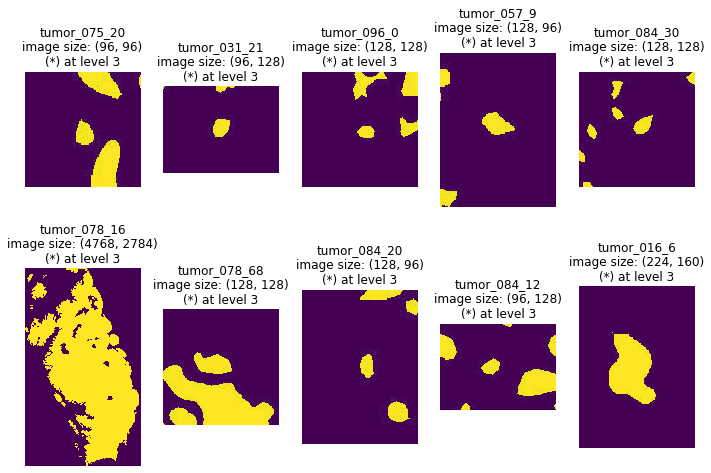

In [ ]:
show_random_tumors()



## Extract coordinates of 256x256 patches. determine the patch label, positive or negative 

In [ ]:
columns= ['slide_name','tumor_name','x','y']
rows = []
for s in tumors_df2['slide_name'].unique():
  tumors = tumors_df2[tumors_df2['slide_name']==s][['x','y','width','height','tumor_name']]
  coords = []
  for t in tumors.values:
    _= [coords.append((s,t[4],x,y)) for x in range(t[0],t[0]+t[2],256) for y in range(t[1],t[1]+t[3],256)]
  coords = list(set(coords))
  rows.extend(({'slide_name':sn,'tumor_name':tn,'x':x,'y':y } for sn,tn,x,y in coords))
patches_df3 = pd.DataFrame(rows, columns = columns)
summarybyslide = patches_df3.groupby('slide_name').agg(total = ('slide_name', lambda x: x.size),
                                      unique = ('tumor_name', lambda x: x.nunique())
                                      ).reset_index().rename(columns={'total':'Patches','unique' : 'Tumors'})



totalpatches = patches_df3.shape[0]
test_slides = ['tumor_094','tumor_019','tumor_016','tumor_031']
val_slides = ['tumor_064','tumor_057','tumor_101','tumor_091']

totalpatchesintest = patches_df3[patches_df3['slide_name'].isin(test_slides)].shape[0]
totalpatchesinval = patches_df3[patches_df3['slide_name'].isin(val_slides)].shape[0]

,index,slide_name,tumor_name,x,y,slide_path,mask_path,minidx,patch_name
0,0,tumor_001,tumor_001_0,69632,131328,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_0_0
1,1,tumor_001,tumor_001_0,69632,131584,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_0_1
2,2,tumor_001,tumor_001_0,69632,131840,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_0_2
3,3,tumor_001,tumor_001_0,69632,132096,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_0_3
4,4,tumor_001,tumor_001_0,69632,132352,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_0_4
...,...,...,...,...,...,...,...,...,...
547,547,tumor_001,tumor_001_1,73472,126976,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_1_547
548,548,tumor_001,tumor_001_1,73472,127232,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_1_548
549,549,tumor_001,tumor_001_1,73472,127488,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_1_549
550,550,tumor_001,tumor_001_1,73472,127744,/content/drive/My Drive/deeplearning/cancer_cl...,/content/drive/My Drive/deeplearning/cancer_cl...,0,tumor_001_1_550


## Summary extracted patches

In [ ]:
print('Total number of patches is {}'.format(totalpatches))
print('Total number of patches in test slides {}'.format(totalpatchesintest))
print('Total number of patches in validation slides {}'.format(totalpatchesinval))
print('Total number of patches in training slides {}'.format(totalpatches - totalpatchesintest - totalpatchesinval))


Total number of patches is 106562
Total number of patches in test slides 15028
Total number of patches in validation slides 12892
Total number of patches in training slides 78642


In [ ]:
summarybyslide

,slide_name,Patches,Tumors
0,tumor_001,552,2
1,tumor_002,77,1
2,tumor_005,192,4
3,tumor_012,72,1
4,tumor_016,4879,7
5,tumor_019,170,4
6,tumor_023,227,6
7,tumor_031,8199,72
8,tumor_035,48,3
9,tumor_057,331,20


In [ ]:
patches_df = patches_df3[~patches_df3['slide_name'].isin(test_slides)]
patches_df = patches_df.sort_values(by=['slide_name','tumor_name','x','y']).reset_index(drop = True)
patches_df['slide_path'] = patches_df['slide_name'].apply(lambda x: [s for s in slide_files if x in s][0])
patches_df['mask_path'] = patches_df['slide_name'].apply(lambda x: [s for s in mask_files if x in s][0])
patches_df.reset_index(drop=False, inplace=True)
patches_df['minidx'] = patches_df.groupby('slide_name')['index'].transform('min')
patches_df['patch_name'] =patches_df.apply(lambda x: '{}_{}'.format(x[2], x[0]-x[-1]), axis = 1)
patches_df.loc[~patches_df['slide_name'].isin(val_slides),'set']='train'
patches_df.loc[patches_df['slide_name'].isin(val_slides),'set']='val'



In [ ]:
current_slide = ''
a = patches_df.loc[i:lastpatch][['slide_name','mask_path']].drop_duplicates().values
for s,m in a[:5]:
  mask = open_slide(m)
  print(s)
  totalpatches_in_slide = patches_df.loc[patches_df['slide_name']==s,'tumor_index'].shape[0]
  print('Total patches in slide : {}'.format(totalpatches_in_slide))
  patches_df.loc[patches_df['slide_name']==s,'tumor_index'] =   patches_df.loc[patches_df['slide_name']==s].apply(lambda x: tumor_idx(mask,0,x['x'],x['y'],256,256), axis = 1)

tumor_001
Total patches in slide : 552
tumor_002
Total patches in slide : 77
tumor_005
Total patches in slide : 192
tumor_012
Total patches in slide : 72
tumor_023
Total patches in slide : 227
tumor_035
Total patches in slide : 48
tumor_057
Total patches in slide : 331
tumor_059
Total patches in slide : 42
tumor_064
Total patches in slide : 4845
tumor_075
Total patches in slide : 3285
tumor_078
Total patches in slide : 37673


In [ ]:
thr = 0.1
patches_df['label'] = patches_df['tumor_index'].apply(
    lambda x: 'negative' if x == 0 else ('positive' if x >= thr else 'not use'))
patches_df['patch_path'] = patches_df.apply(
    lambda x: os.path.join('patches',x['set'],x['label'],x['patch_name']+'.jpg'),axis=1)

In [ ]:
_=[os.makedirs(os.path.join('patches',s,l), exist_ok = True) for s in ['train','val','test'] for l in ['positive','negative']]

In [ ]:
current_slide = ''
a = patches_df.loc[i:lastpatch][['slide_name','slide_path']].drop_duplicates().values
for s,sp in a:
  start_time = time.time()
  now = time.strftime("%H:%M", time.localtime(start_time))
  print("Start Time {} ".format(now)) 
  slide = open_slide(sp)
  print(s)
  totalpatches_in_slide = patches_df.loc[patches_df['slide_name']==s,'tumor_index'].shape[0]
  print('Total patches in slide : {}'.format(totalpatches_in_slide))
  patches_df.loc[(patches_df['slide_name']==s) & (patches_df['label']!='not use')].apply(lambda x: save_patch(slide,0,x['x'],x['y'],256,256, x['patch_path']), axis = 1)
  end_time = time.time()
  now = time.strftime("%H:%M", time.localtime(end_time))
  print("End Time {} ".format(now)) 
  print('....'*10)

tumor_001
Total patches in slide : 552
tumor_002
Total patches in slide : 77
tumor_005
Total patches in slide : 192
tumor_012
Total patches in slide : 72
tumor_023
Total patches in slide : 227
tumor_035
Total patches in slide : 48
tumor_057
Total patches in slide : 331
tumor_059
Total patches in slide : 42
tumor_064
Total patches in slide : 4845
tumor_075
Total patches in slide : 3285
tumor_078
Total patches in slide : 37673


In [ ]:
shutil.make_archive('patchesnew', 'zip', 'patches')
shutil.copy('patchesnew.zip',project_root_dir)

'/content/drive/My Drive/deeplearning/cancer_classification/patchesnew.zip'

In [ ]:
shutil.copy(os.path.join(project_root_dir,'patchesnew.zip'),colab_root_dir)
!unzip -q 'patchesnew' -d "patches"

In [ ]:
train_dir = os.path.join('patches', 'train')
val_dir = os.path.join('patches', 'val')
# test_dir = os.path.join('patches', 'test')
print('Total train negative images:', len(os.listdir(train_dir+'/negative')))
print('Total train positive images:', len(os.listdir(train_dir+'/positive')))
print('Total validation negative images:', len(os.listdir(val_dir+'/negative')))
print('Total validation positive images:', len(os.listdir(val_dir+'/positive')))
#print('Total test negative images:', len(os.listdir(test_dir+'/negative')))
#print('Total test positive images:', len(os.listdir(test_dir+'/positive')))


Total train negative images: 21385
Total train positive images: 19308
Total validation negative images: 2425
Total validation positive images: 2497


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       2

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
                                   )
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size=(150, 150),
                  batch_size=32,
                  shuffle=True,
                  class_mode='binary'
                  )
val_datagen = ImageDataGenerator( rescale=1./255
                                )
                                 
val_generator = val_datagen.flow_from_directory(
                  val_dir,
                  target_size=(150, 150),
                  batch_size=32,
                  class_mode='binary'
                  )

Found 40693 images belonging to 2 classes.
Found 4922 images belonging to 2 classes.


In [ ]:
conv_base = tf.keras.applications.VGG16(include_top=False,
                                              weights='imagenet',
                                              input_shape=(150, 150, 3))
conv_base.trainable = False
#fine tune  conv_base
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':set_trainable = True
  if set_trainable:layer.trainable = True
  else:layer.trainable = False

conv_base.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['acc'])
history = model.fit_generator(
          train_generator,
          steps_per_epoch=50,
          epochs=50,
          validation_data=val_generator,
          validation_steps=50
          )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 12s 244ms/step - loss: 0.6216 - acc: 0.5944 - val_loss: 0.6513 - val_acc: 0.5869
Epoch 2/50
50/50 [==============================] - 11s 221ms/step - loss: 0.6843 - acc: 0.6419 - va

In [ ]:
model.save(os.path.join(project_root_dir,'model_inc.h5'))

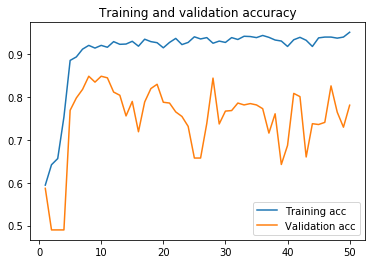

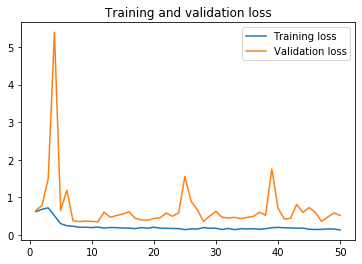

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
def copy_files(slide_path):
  global slide_name, mask_path, patches_folder_name,predictions_path
  slide_name = pathlib.Path(slide_path).stem
  mask_path = [m for m in mask_files if slide_name in m][0]
  patches_folder_path = os.path.join(eval_dir,slide_name,'patches_'+slide_name+'.zip')
  patches_folder_name = 'patches_'+slide_name
  predictions_path = os.path.join(eval_dir,slide_name,'pred_'+slide_name+'.pkl')
  patches_locator_name = patches_folder_name+'_locators.npy'
  patches_locators_path = os.path.join(eval_dir,slide_name,patches_locator_name)

  shutil.copy(patches_folder_path,colab_root_dir)
  shutil.copy(predictions_path,colab_root_dir)
  shutil.copy(patches_folder_path,colab_root_dir)
  shutil.copy(patches_locators_path,colab_root_dir)
  !unzip -q -o $patches_folder_name -d $patches_folder_name

def read_slide(slide, level, x, y, width, height):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    im = np.asarray(im)
    return im
def read_mask(mask, level, x, y, width, height):
    msk = mask.read_region((x,y), level, (width, height))
    msk = msk.convert('RGB') # drop the alpha channel
    msk = np.asarray(msk)
    msk = msk[:,:,0]
    return msk

In [ ]:
model = load_model(os.path.join(project_root_dir,'model_inc.h5'))


In [ ]:
eval_dir = os.path.join(project_root_dir,'eval')
def image_gen(img_paths, img_size=(150, 150)):
    for img_path in img_paths:
        img = mpimg.imread(img_path) / 255.
        img = cv.resize(img, img_size)
        img = np.expand_dims(img, axis=0) 
        img_name = pathlib.Path(img_path).stem
        i = int(img_name.split('_')[-1])
        x,y,w,h = patch_locators_in[i]
        level = 0
        truth = 1 if read_slide(mask_path,level, x,y,w,h).sum() > 0 else 0
        yield img_name,img,truth, (x,y,w,h)
def predict(slide_path):
  global patch_locators_in, mask_path
  slide_name = pathlib.Path(slide_path).stem
  print('Predictions for slide {}'.format(slide_name))
  mask_path = [m for m in mask_files if slide_name in m][0]
  patches_folder_path = os.path.join(eval_dir,slide_name,'patches_'+slide_name+'.zip')
  patches_folder_name = 'patches_'+slide_name
  shutil.copy(patches_folder_path,colab_root_dir)
  !unzip -q -o $patches_folder_name -d $patches_folder_name
  patches_locator_name = patches_folder_name+'_locators.npy'
  patches_locators_path = os.path.join(eval_dir,slide_name,patches_locator_name)
  shutil.copy(patches_locators_path,colab_root_dir)
  cols = ['patch_name','x','y','width','height','truth','prediction']
  rows = []
  img_paths = [os.path.join(colab_root_dir,patches_folder_name,f) for f in os.listdir(patches_folder_name)]
  patch_locators_in = np.load(patches_locator_name,allow_pickle = True)
  eval_generator = image_gen(img_paths)
  predictions_name = 'pred_'+pathlib.Path(slide_name).stem
  predictions_path = os.path.join(eval_dir,predictions_name)
  start_time = time.time()
  now = time.strftime("%H:%M", time.localtime(start_time))
  print("Start Time {} ".format(now)) 
  for patchname , img , truth, c in eval_generator:
    predictions = model.predict(img).item()
    rows.append({'patch_name': patchname,'x':c[0],'y':c[1],'width':c[2],'height':c[3], 'truth':truth,'prediction':predictions})
  predictions_df = pd.DataFrame(rows, columns = cols)
  predictions_df.to_pickle('pred_'+slide_name+'.pkl')
  shutil.copy('pred_'+slide_name+'.pkl',os.path.join(eval_dir,slide_name,'pred_'+slide_name+'.pkl'))
  end_time = time.time()
  now = time.strftime("%H:%M", time.localtime(end_time))
  print("End Time {} ".format(now)) 
  print('....'*10)

In [ ]:
slide_name = 'tumor_031'
slide_path = [s for s in slide_files if slide_name in s][0]
slide_path = [s for s in slide_files if slide_name in s][0]
mask_path =  [s for s in mask_files if slide_name in s][0]
slide = open_slide(slide_path)
mask = open_slide(mask_path)
#predict(slide_path)

Predictions for slide tumor_031
Start Time 23:23 
End Time 23:34 
........................................


In [ ]:
slide_name = 'tumor_031'
slide_path = [s for s in slide_files if slide_name in s][0]
slide_path = [s for s in slide_files if slide_name in s][0]
mask_path =  [s for s in mask_files if slide_name in s][0]
slide = open_slide(slide_path)
mask = open_slide(mask_path)
w,h =slide.level_dimensions[7]
img = read_slide(slide,level=7,x=0,y=0,width=w,height=h)
msk = read_mask(mask,level=7,x=0,y=0,width=w,height=h)


(1728, 764)

In [ ]:
pred_file = os.path.join(eval_dir,slide_name,'pred_'+slide_name+'.pkl')
shutil.copy(pred_file, colab_root_dir)
predictions_df = pd.read_pickle(pred_file)

In [ ]:
thr = 0.9
tp = predictions_df[predictions_df['truth']==1]['prediction'].apply(lambda x: 1 if x > thr else 0).sum()
tn = predictions_df[predictions_df['truth']==0]['prediction'].apply(lambda x: 1 if x <= thr else 0).sum()
fp = predictions_df[predictions_df['truth']==0]['prediction'].apply(lambda x: 1 if x > thr else 0).sum()
fn = predictions_df[predictions_df['truth']==1]['prediction'].apply(lambda x: 1 if x <= thr else 0).sum()
predictions_df.shape, tp, tn, fp, fn

((7936, 7), 1821, 5338, 114, 663)

In [ ]:
def lesion_maps(predictions_df,threshold):
  w,h =slide.level_dimensions[0]
  pred_pos = predictions_df[predictions_df['prediction']>=threshold][['x','y']].sort_values(by=['x','y']).reset_index(drop=True)
  heatmap = np.asarray(Image.new('RGB', (w//256,h//256), color=(0, 0, 255))).copy()
  for x, y in pred_pos.values:
    heatmap[y//256,x//256] = [255,0,0]
  true_pos = predictions_df[predictions_df['truth']==1][['x','y']].sort_values(by=['x','y']).reset_index(drop=True)
  pred_pos = predictions_df[predictions_df['prediction']>threshold][['x','y']].sort_values(by=['x','y']).reset_index(drop=True)
  

  ##Superimposed image
  w,h =slide.level_dimensions[7]
  img = read_slide(slide,level=7,x=0,y=0,width=w,height=h)
  msk = read_mask(mask,level=7,x=0,y=0,width=w,height=h)
  
  heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
  heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
  superimposed_img = (heatmap *0.4 + img)
  superimposed_img /= superimposed_img.max()
  

  
  ###Lesion region
  xmin = true_pos['x'].min()
  ymin = true_pos['y'].min()
  w = true_pos['x'].max() - xmin + 256
  h = true_pos['y'].max() - ymin + 256
  lesion_heatmap = np.asarray(Image.new('RGB', (w//256,h//256), color=(0, 0, 255))).copy()
  for x, y in pred_pos.values:
    if (y>=ymin) &  (y-ymin < h) & (x>=xmin) & (x-xmin < w):
      try:
        lesion_heatmap[(y-ymin)//256,(x-xmin)//256] = [255,0,0]
      except: 
        print(lesion_heatmap.shape,h//256,w/256,(y-ymin)//256,(x-xmin)//256)
  for lv in range(8):
    if w*h//2**(2*lv) >1e6:continue
    else: 
      level = lv
      break
  lesionmask = read_mask(mask,level= level , x = xmin, y=ymin, width = w//2**level, height = h//2**level)
  lesion = read_slide(slide,level= level , x = xmin, y=ymin, width = w//2**level, height = h//2**level)

  #####Superimposed image around lesion area
  lesion_heatmap = cv.resize(lesion_heatmap, (lesion.shape[1], lesion.shape[0]))
  lesion_heatmap = cv.applyColorMap(lesion_heatmap, cv.COLORMAP_JET)
  lesion_heatmap = cv.applyColorMap(lesion_heatmap, cv.COLORMAP_JET)
  superimposed_lesion = (lesion_heatmap *0.4 + lesion)
  superimposed_lesion /= superimposed_lesion.max()
  return img,msk,heatmap,superimposed_img,lesion,lesionmask,lesion_heatmap,superimposed_lesion


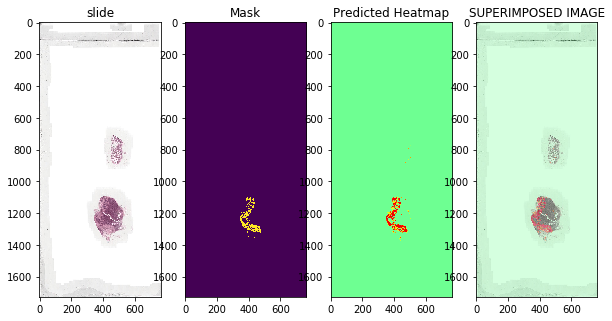

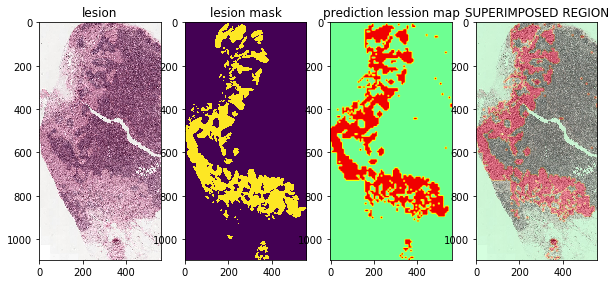

In [ ]:
slide_name = 'tumor_031'
slide_path = [s for s in slide_files if slide_name in s][0]
mask_path = [s for s in mask_files if slide_name in s][0]

#copy_files(slide_path)
slide = open_slide(slide_path)
mask = open_slide(mask_path)
predictions_df = pd.read_pickle(predictions_path)
img,msk,heatmap,superimposed_img,lesion,lesionmask,lesion_heatmap,superimposed_lesion = lesion_maps(predictions_df,threshold=0.9)
fig,axs = plt.subplots(nrows=1, ncols = 4, figsize = (10,20))
axs[0].imshow(img)
axs[0].set_title('slide')
w,h =slide.level_dimensions[7]
axs[1].imshow(msk)
axs[1].set_title('Mask')
axs[2].imshow(heatmap)
axs[2].set_title('Predicted Heatmap')
axs[3].imshow(superimposed_img)
axs[3].set_title('SUPERIMPOSED IMAGE')
plt.show()
fig,axs = plt.subplots(nrows=1, ncols = 4, figsize = (10,20))
axs[0].imshow(lesion)
axs[0].set_title('lesion')
axs[1].imshow(lesionmask)
axs[1].set_title('lesion mask')
axs[2].imshow(lesion_heatmap)
axs[2].set_title('prediction lession map')
axs[3].imshow(superimposed_lesion)
axs[3].set_title('SUPERIMPOSED REGION')
plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)